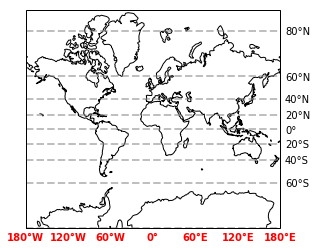

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.show()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
import xarray as xr
import letkf_forecasting.letkf_io as letkf_io
import letkf_forecasting.analyse_results as analyse_results
from letkf_forecasting import prepare_sat_data

In [4]:
from owslib.wms import WebMapService

In [5]:
%matplotlib inline

In [6]:
year = 2014
month = 5
day = 29

In [7]:
CI = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
CI = CI['ci']
CI = letkf_io.add_crop_attributes(CI)
CI_ed = analyse_results.return_error_domain(CI)
x_full = CI.west_east.values
y_full = CI.south_north.values
x_full, y_full = np.meshgrid(x_full, y_full)
lats_full, lons_full = prepare_sat_data.lcc_to_sphere(x=x_full, y=y_full)

x_ed = CI_ed.west_east.values
y_ed = CI_ed.south_north.values
x_ed, y_ed = np.meshgrid(x_ed, y_ed)
lats_ed, lons_ed = prepare_sat_data.lcc_to_sphere(x=x_ed, y=y_ed)

In [8]:
results_CI = xr.open_dataset(
    f'/a2/uaren/travis/results/2014/05/29/wrf_001/20140529_1630Z.nc')
x_cd = results_CI.west_east.values
y_cd = results_CI.south_north.values
x_cd, y_cd = np.meshgrid(x_cd, y_cd)

lats_cd, lons_cd = prepare_sat_data.lcc_to_sphere(x=x_cd, y=y_cd)

In [9]:
projection = ccrs.LambertConformal(central_longitude=-113.7,
                                   central_latitude=31.68858,
                                   standard_parallels=(31.68858, 31.68858),
                                   globe=ccrs.Globe(ellipse='sphere'))

In [10]:
def xy_corners(lons, lats, projection):
    corners = [[0, 0, -1, -1, 0], [0, -1, -1, 0, 0]]
    xys = projection.transform_points(ccrs.Geodetic(), lons[corners], lats[corners])
    xys = np.array(xys[:, :2])
    return xys

In [11]:
corners_full = xy_corners(lons_full, lats_full, projection)
corners_ed = xy_corners(lons_ed, lats_ed, projection)
corners_cd = xy_corners(lons_cd, lats_cd, projection)

In [12]:
import cartopy.geodesic as cgeo


def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

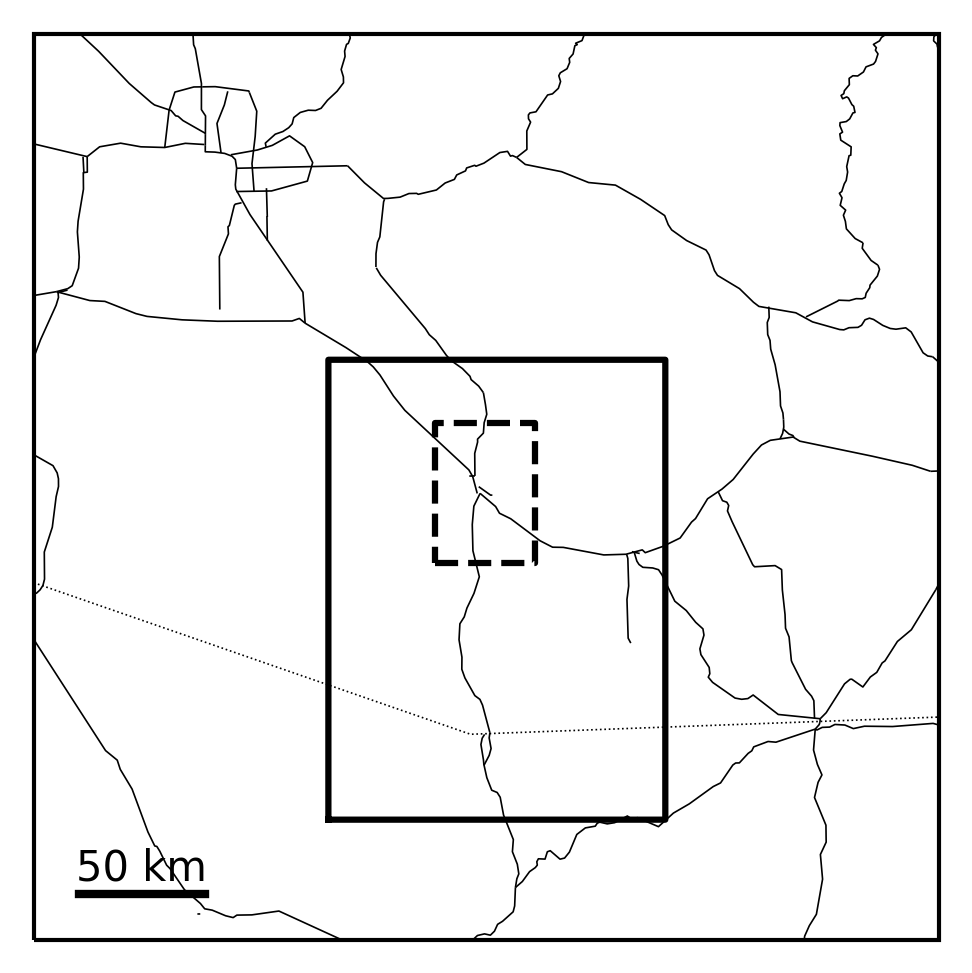

In [13]:
plt.figure(dpi=300)

ax = plt.subplot(111, projection=projection)

ax.set_extent([corners_full[0, 0], corners_full[1, 0], corners_full[0, 1], corners_full[2, 1]],
              crs=projection)

ax.plot(corners_cd[:, 0],
        corners_cd[:, 1],
        'k',
        lw=1.5,
        transform=projection)

ax.plot(corners_ed[:, 0],
        corners_ed[:, 1],
        'k--',
        lw=1.5,
        transform=projection)

layer = 'BlueMarble_NextGeneration'

scale_bar(ax, (0.05, 0.05), 50, linewidth=2)
# scale_bar(ax, (0.65, 0.4), 6_000)

# url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
# ax.add_wmts(url, layer)

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=.4)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'roads', '10m', facecolor='none'),
               facecolor='none', edgecolor='k', linewidth=.4)
# ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'urban_areas', '10m'), facecolor='k')

# ax.set_title('Computational and Error Domains')

RuntimeError: Cannot handle non-rectangular coordinate systems.

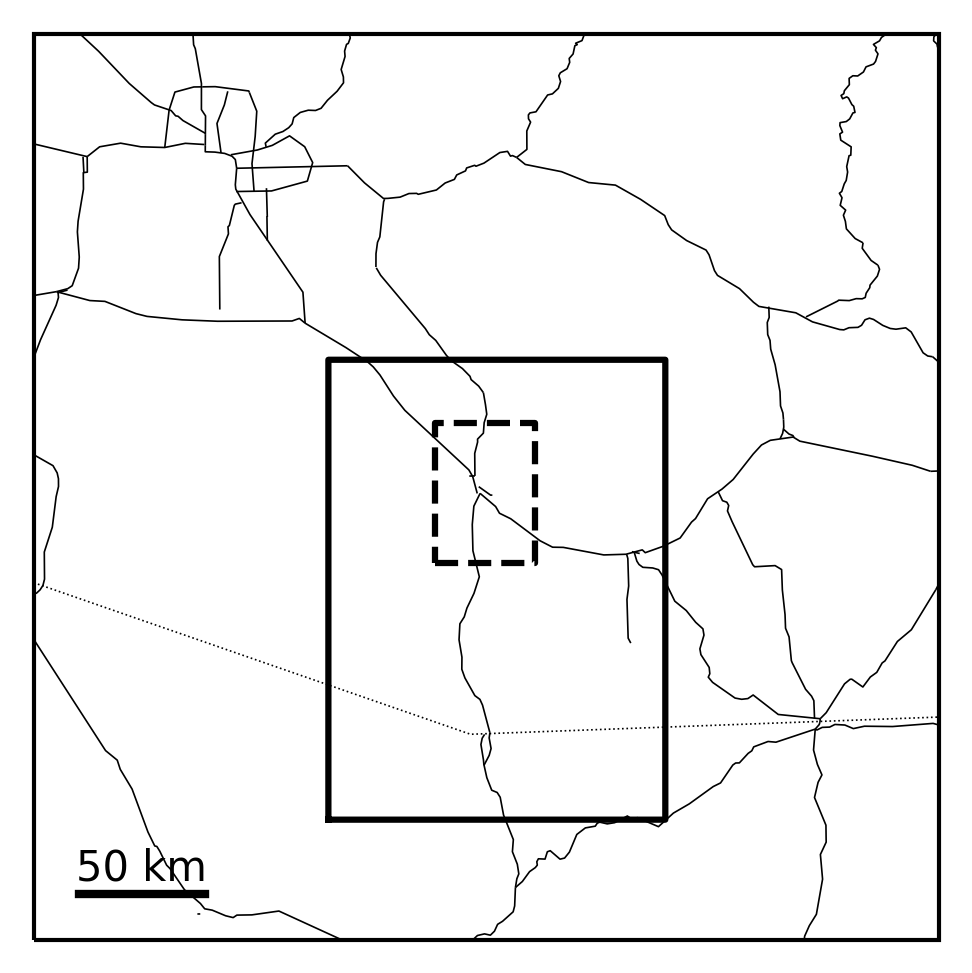

In [18]:
plt.figure(dpi=300)

ax = plt.subplot(111, projection=projection)

ax.set_extent([corners_full[0, 0], corners_full[1, 0], corners_full[0, 1], corners_full[2, 1]],
              crs=projection)

ax.plot(corners_cd[:, 0],
        corners_cd[:, 1],
        'k',
        lw=1.5,
        transform=projection)

ax.plot(corners_ed[:, 0],
        corners_ed[:, 1],
        'k--',
        lw=1.5,
        transform=projection)

layer = 'BlueMarble_NextGeneration'

scale_bar(ax, (0.05, 0.05), 50, linewidth=2)
# scale_bar(ax, (0.65, 0.4), 6_000)

# url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
# ax.add_wmts(url, layer)

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=.4)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'roads', '10m', facecolor='none'),
               facecolor='none', edgecolor='k', linewidth=.4)
# ax.set_title('Computational and Error Domains')

ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())